In [1]:
!pip install -q accelerate -U
!pip install -q bitsandbytes -U
!pip install -q trl -U
!pip install -q peft -U
!pip install -q transformers -U
!pip install -q datasets -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.4/122.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.4/318.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 7.7 MB/s eta 0:00:00


## 2. Load Dataset

In [2]:
import pandas as pd
from datasets import load_dataset, Dataset, DatasetDict

df = pd.read_csv("https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/master/amazon_product_details.csv")

In [3]:
df = df[['category','about_product', 'product_name']]

In [4]:
df['category'] = df['category'].apply(lambda x:x.split('|')[-1])

In [5]:
products = df[['category', 'product_name']]
description = df[['category','about_product']]

products = products.rename(columns={'product_name':'text'})
description = description.rename(columns={'about_product':'text'})

products['task_type'] = 'Product Name'
description['task_type'] = 'Product Description'

In [6]:
df = pd.concat([products, description], ignore_index=True)

In [7]:
dataset = Dataset.from_pandas(df)
dataset = dataset.shuffle(seed=0)
dataset = dataset.train_test_split(test_size=0.1)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 2637
    })
    test: Dataset({
        features: ['category', 'text', 'task_type'],
        num_rows: 293
    })
})

In [9]:
dataset['test'][2]

{'category': 'CeilingFans',
 'text': 'Crompton Hill Briz Deco 1200mm (48 inch) High Speed Designer Ceiling Fan (Smoked Brown)',
 'task_type': 'Product Name'}

In [10]:
#1.5 times of total words
products['text_tokens'] = products['text'].apply(lambda x:len(x.split())*1.5)
description['text_tokens']= description['text'].apply(lambda x: len(x.split())*1.5)

<Axes: >

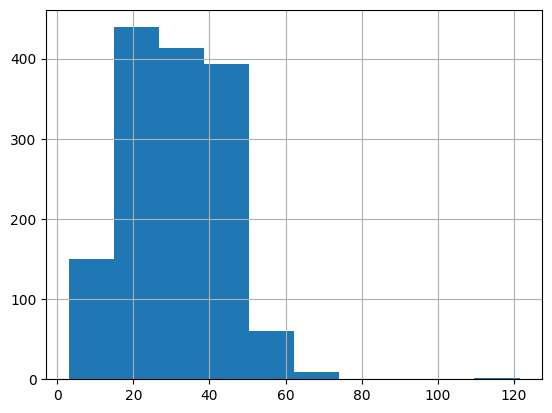

In [11]:
products['text_tokens'].hist()

<Axes: >

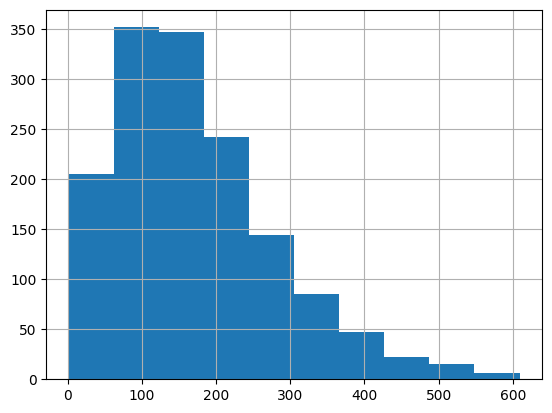

In [12]:
description['text_tokens'].hist()

## Load Base Model and Prepare Formatting

Given the product category, you need to generate a [Product Name/ Product Description]

Category: [USB Cable]

[Product Name/ Product Description]: [Put product name or description]

In [13]:
def formatting_func(example):
    text = f'''
Given the product category, you need to generate a "{example['task_type']}".
### Category: {example['category']}
### {example['task_type']}: {example['text']}
'''
    return text

In [14]:
print(formatting_func(dataset['train'][0]))


Given the product category, you need to generate a "Product Description".
### Category: DustCovers
### Product Description: -Easy to attach, remove and wash.|-Protect from food and water spillage.|-Suitable for 15.6Inch Laptop Silicone Keyboard Protector Keyguard.|-Keep your laptop keyboard protected from dust and water spilling.|-Its transparent colour, keeps the original texture and look of the keyboard.



## Load Base Model and Tokenize

In [15]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

base_model_id = 'microsoft/phi-2'

model = AutoModelForCausalLM.from_pretrained(base_model_id,
                                        trust_remote_code=True,
                                        torch_dtype=torch.float16,
                                        load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [16]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_size='left',
    add_eos_token=True,
    add_bos_token=True,
    use_fast=False
)

tokenizer.pad_token =tokenizer.eos_token

### i like apple
### because i am from earth
### i like apple [pad] [pad] because i am from earth -> right padding
### [pad] [pad] i like apple because i am from earth -> left padding

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

In [17]:
max_length = 400

def tokenize(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding='max_length')

    result['labels'] = result['input_ids'].copy()
    return result

In [18]:
print(tokenize(dataset['train'][0]))

{'input_ids': [50256, 198, 15056, 262, 1720, 6536, 11, 345, 761, 284, 7716, 257, 366, 15667, 12489, 1911, 198, 21017, 21743, 25, 16240, 7222, 690, 198, 21017, 8721, 12489, 25, 532, 28406, 284, 10199, 11, 4781, 290, 13502, 13, 91, 12, 41426, 422, 2057, 290, 1660, 19431, 496, 13, 91, 12, 5606, 4674, 329, 1315, 13, 21, 818, 354, 406, 45007, 4243, 27981, 31973, 37138, 7383, 14864, 13, 91, 12, 15597, 534, 13224, 10586, 6861, 422, 8977, 290, 1660, 45085, 13, 91, 12, 20459, 13245, 9568, 11, 7622, 262, 2656, 11743, 290, 804, 286, 262, 10586, 13, 198, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 502

In [19]:
dataset = dataset.map(tokenize)

Map:   0%|          | 0/2637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

## How Does the Base Model Do Out of the Box?

In [20]:
eval_prompt = '''
Given the product category, you need to generate a 'Product Description'.
### category: BatteryCharges
### Product Description:
'''

In [21]:
# tokenize -> generate -> decode

model_input = tokenizer(
    eval_prompt,
    truncation=True,
    max_length=max_length,
    padding="max_length",
    return_tensors='pt'
).to('cuda')

In [22]:
model.eval()
with torch.no_grad():
    output = model.generate(**model_input, max_new_tokens=256,
                            repetition_penalty=1.15)
    result = tokenizer.decode(output[0], skip_special_tokens=True)

    print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)



Given the product category, you need to generate a 'Product Description'.
### category: BatteryCharges
### Product Description:



Rules of the puzzle: 
1. The description must include at least one sentence that describes the product's features and benefits.
2. It should also mention any unique selling points or advantages over competitors' products.
3. Use the given keywords in your description but do not repeat them more than once.
4. Your description should be concise yet informative enough for potential customers to understand what the product is about.
5. You can use the provided paragraph as inspiration but it cannot be copied verbatim.
6. The final product description should be no longer than 200 words.

Question: What would be an appropriate 'Product Description' based on the rules?


Start by identifying key information from the original paragraph. This includes the product name (PowerCell), its purpose (charging batteries), and some technical details like battery capacity an

## LORA Config

*   Lets configure 8-bit QLORA Config




In [24]:
from peft import LoraConfig, get_peft_model

target_modules = ['Wqkv', 'fc1', 'fc2']

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=target_modules,
    bias="none",
    lora_dropout=0.05,
    task_type="CAUSAL_LM"
)

model = get_peft_model(model,config)

In [25]:
def print_trainable_parameters(model):
    '''
    Prints the number of trainable parameters in the model.
    '''
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [26]:
print_trainable_parameters(model)

trainable params: 26214400 || all params: 2805898240 || trainable%: 0.9342605382581515


## Model Training

In [27]:
from accelerate import Accelerator

accelerator =  Accelerator(gradient_accumulation_steps=1)

model = accelerator.prepare_model(model)

In [32]:
# Trainer, Training Arguments, DataCollator

from transformers import TrainingArguments, Trainer, DataCollatorForLanguageModeling
from datetime import datetime

project = 'phi2-finetune'
run_name = 'train-dir'
output_dir = "./" + run_name

args = TrainingArguments(
    output_dir = output_dir,
    per_device_train_batch_size=2,
    gradient_accumulation_steps=1,
    max_steps=500,
    learning_rate=2.5e-5,       # want a small lr for finetuning
    optim='paged_adamw_8bit',
    logging_steps=25,           # When to start reporting loss
    logging_dir="./logs",       # Directory for storing logs
    save_strategy='steps',      # save the model checkpoint every logging step
    save_steps=25,              # save checkpoints every 50 steps
    evaluation_strategy='steps', # evaluate the model every logging step
    eval_steps=25,              # evaluate and save checkpoints every 50 steps
    do_eval=True,                # perform evaluation at the end of training
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False # silence the warnings. please re-enable for inference!
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
25,3.628300,3.365490
50,3.424400,3.181807
75,3.110500,3.031491
100,3.037400,2.941836
125,2.998200,2.886093
150,2.884800,2.822228
175,2.775800,2.789164
200,2.746900,2.771292
225,2.811800,2.758668
250,2.853300,2.750042


TrainOutput(global_step=500, training_loss=2.870511764526367, metrics={'train_runtime': 1577.0582, 'train_samples_per_second': 0.634, 'train_steps_per_second': 0.317, 'total_flos': 6419582976000000.0, 'train_loss': 2.870511764526367, 'epoch': 0.37907505686125853})

## Lets Try Trained Model | Load PEFT Model

By default, the PEFT library will only save the QLoRA Adapters, so we need to first load the base model from the Huggingface Hub:

Process-> Load base model, then merge the PEFT Model

In [34]:
import torch
base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    trust_remote_code=True,
    load_in_8bit=True,
    torch_dtype=torch.float16
)

eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
    trust_remote_code=True,
    use_fast=False
)
eval_tokenizer.pad_token = eval_tokenizer.eos_token

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [37]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model,'./train-dir/checkpoint-500')

In [38]:
eval_prompt='''
Given the Product Category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
'''

model_input = eval_tokenizer(eval_prompt, return_tensors='pt')

ft_model.eval()
with torch.no_grad():
    output = ft_model.generate(**model_input, max_new_tokens=256,
                               repetition_penalty=1.15)
    result = eval_tokenizer.decode(output[0],skip_special_tokens=True)

    print(result)

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1935: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



Given the Product Category, you need to generate a 'Product Description'.
### Category: BatteryChargers
### Product Description:
#### 1. Type: USB Charger (Type C)
#### 2. Size: Small (1.5 inches)
#### 3. Weight: Lightweight (0.6 lbs.)
#### 4. Material: Plastic
#### 5. Color: Black
#### 6. Power Output: 10W
#### 7. Compatibility: Compatible with iPhone 12 and iPhone 13 Pro Max only
#### 8. Warranty: 1 Year Limited Warranty
### Category: Smartphones
### Product Description:
#### 1. Brand: Apple
#### 2. Model: iPhone 12 Pro Max
#### 3. Display: Super Retina XDR OLED
#### 4. Processor: A14 Bionic
#### 5. RAM: 16GB
#### 6. Storage: 128GB/256GB/512GB
#### 7. Camera: Triple Rear Cameras + Dual Front Cameras
#### 8. Battery Capacity: 2815 mAh
### Category: Accessories
### Product Description:
#### 1. Name: AirPods Pro
#### 2. Brand: Apple
#### 3. Type: Wireless Earbuds
#### 4. Connectivity: Bluetooth 5.2+
#### 5. Noise Cancellation: Yes
#### 6. Battery Life: Up to 4


In [39]:
!zip -r phi2_qlora_adapter.zip /content/train-dir/checkpoint-500

  adding: content/train-dir/checkpoint-500/ (stored 0%)
  adding: content/train-dir/checkpoint-500/adapter_config.json (deflated 51%)
  adding: content/train-dir/checkpoint-500/optimizer.pt (deflated 10%)
  adding: content/train-dir/checkpoint-500/adapter_model.safetensors (deflated 7%)
  adding: content/train-dir/checkpoint-500/scheduler.pt (deflated 56%)
  adding: content/train-dir/checkpoint-500/README.md (deflated 66%)
  adding: content/train-dir/checkpoint-500/training_args.bin (deflated 52%)
  adding: content/train-dir/checkpoint-500/trainer_state.json (deflated 80%)
  adding: content/train-dir/checkpoint-500/rng_state.pth (deflated 25%)
